#Detecting Harmful Algal Blooms with perturbed calibration

This notebook shows the workflow of the impact of calibration errors on harmful algal bloom detection using MODIS imagery. It uses the Google Earth Engine python API.

Author: Sheila Baber (sbaber@mit.edu)

Date: April 15, 2020

In [ ]:
import ee
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()



To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=hfQRoQKTQy3sABaXqTuvPO-FuKZ7US9uIdWtCILdhFw&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g6oymrsa61AJaCfQoV4wJ0uyL65gYvEdr4ISqkibAxd9vE5h8GdZ2E

Successfully saved authorization token.


##Visualizing the data

(Sourced from Eric Magliarditi '20) 

In [ ]:
#this is from Eric Magliarditi
!pip install geopandas
!pip install julian

import numpy as np
import torch
import PIL
import ee
import folium
from IPython.display import Image
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from tqdm import trange
import seaborn as sns
import matplotlib.pyplot as plt
import julian
import plotly.express as px
import plotly.graph_objects as go


def add_ee_layer(self, ee_object, vis_params, name):
	
	try:    
		# display ee.Image()
		if isinstance(ee_object, ee.image.Image):    
			map_id_dict = ee.Image(ee_object).getMapId(vis_params)
			folium.raster_layers.TileLayer(
			tiles = map_id_dict['tile_fetcher'].url_format,
			attr = 'Google Earth Engine',
			name = name,
			overlay = True,
			control = True
			).add_to(self)
		# display ee.ImageCollection()
		elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
			ee_object_new = ee_object.mosaic()
			map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
			folium.raster_layers.TileLayer(
			tiles = map_id_dict['tile_fetcher'].url_format,
			attr = 'Google Earth Engine',
			name = name,
			overlay = True,
			control = True
			).add_to(self)
		# display ee.Geometry()
		elif isinstance(ee_object, ee.geometry.Geometry):    
			folium.GeoJson(
			data = ee_object.getInfo(),
			name = name,
			overlay = True,
			control = True
		).add_to(self)
		# display ee.FeatureCollection()
		elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
			ee_object_new = ee.Image().paint(ee_object, 0, 2)
			map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
			folium.raster_layers.TileLayer(
			tiles = map_id_dict['tile_fetcher'].url_format,
			attr = 'Google Earth Engine',
			name = name,
			overlay = True,
			control = True
		).add_to(self)
	
	except:
		print("Could not display {}".format(name))

folium.Map.add_ee_layer = add_ee_layer

def generate_map(data_dict, air_quality_measure='Nitrogen_Dioxide', city_coordinates=[40.78,-73.9],
				 early_date='2019-04-01', later_date='2019-04-15',
				 opacity=0.4, zoom=8):
	'''
	Creates a visual heat map of corresponding gas - From Sentinel5
	
	..param air_quality_measure: Air Quality metric of analysis
		..must be one of the following: (Nitrogen_Dioxide,UV_Aersol,
			Carbon_Monoxide, Formaldehyde, Ozone, Sulphur_Dioxide, Methane)
	..paramtype air_quality_measure: str
	
	..param city_coordinates: Location of center of map (lat, long)
	..paramtype city_coordinates: list
	
	..param early_date: Beginning date of analysis
	..paramtype early_date: str YYYY-MM-DD
	
	..param later_date: End date of analysis
	..paramtype later_date: str YYYY-MM-DD
	
	..param zoom: Amount to zoom into the map
	..paramtype zoom: int
	
	..return my_map: Folium Map containing the layers
	..rtype: Folium Map
	'''
	
	if air_quality_measure not in ["Nitrogen_Dioxide","UV_Aersol",
			"Carbon_Monoxide", "Formaldehyde", "Ozone", "Sulphur_Dioxide", "Methane"]:
		raise ValueError("Air Quality Measurement is incorrect \n" + \
						"Please use the following: " + \
						 "Nitrogen_Dioxide,UV_Aersol, Carbon_Monoxide, Formaldehyde, Ozone, Sulphur_Dioxide, Methane"
						)
		
	air_quality_dict = data_dict[air_quality_measure]
	sentinel_data = ee.ImageCollection(air_quality_dict.get('dataset')).select(air_quality_dict.get("select"))
	sentinel_data = sentinel_data.filterDate(early_date, later_date)
	
	vis_params = {
	  'min': air_quality_dict.get('min'),
	  'max': air_quality_dict.get('max'),
	  'palette': air_quality_dict.get("palette"),
	  'opacity': opacity
	}

	my_map = folium.Map(location=city_coordinates, zoom_start=zoom, height=400)
	my_map.add_ee_layer(sentinel_data.mean(), vis_params, 'S5P N02')
	my_map.add_child(folium.LayerControl())
	
	return my_map

def create_data_table(region_geom, dataset):
	'''
	Creates data table for single region
	'''
	
	size = dataset.size().getInfo()
	jan_1_1950 = datetime(1950,1,1)
	df = pd.DataFrame()
	
	for i in trange(size):
		image = images.get(i)
		image_info = image.getInfo()
		image_id = image_info.get("id")
		days_since_jan_1_1950 = image_info.get('properties').get("TIME_REFERENCE_DAYS_SINCE_1950")
		date = jan_1_1950 + timedelta(days=days_since_jan_1_1950)
		
		ee_image = ee.Image(image_id)
		
		mean_dict = ee_image.reduceRegion(
			reducer=ee.Reducer.mean(),
			geometry=region_geom,
			scale=100)
		
		result = mean_dict.getInfo()
		if result['NO2_column_number_density']:
			result['Date Acquired'] = date.strftime("%m/%d/%Y")
			result['Image ID'] = image_id
			df = df.append(result,ignore_index=True)
	
	return df

def create_data_table_multi_region(feature_collection, dataset, stat):
	'''
	Creates data table for multiple regions
	'''
	
	size = dataset.size().getInfo()
	images = dataset.toList(dataset.size())
	jan_1_1950 = datetime(1950,1,1)
	df = pd.DataFrame()
	print(size)
	for i in range(size):
		image = images.get(i)
		image_info = image.getInfo()
		image_id = image_info.get("id")
		properties_all = image_info.get('properties')
		days_since_jan_1_1950 = properties_all.get("TIME_REFERENCE_DAYS_SINCE_1950")
		date = jan_1_1950 + timedelta(days=days_since_jan_1_1950)
		julian_date = properties_all.get("TIME_REFERENCE_JULIAN_DAY")
		dt = julian.from_jd(julian_date, fmt='jd')
		system_start = properties_all.get("system:time_start")
		
		ee_image = ee.Image(image_id)
		
		mean_dict = ee_image.reduceRegions(
			reducer=ee.Reducer.mean(),
			collection=feature_collection,
			scale=100)
		
		result = mean_dict.getInfo()
		
		for feature in result.get('features'):
			properties = feature.get('properties')
			if properties.get(stat):
				properties['Date Acquired'] = date #date.strftime("%m/%d/%Y")
				properties['Image ID'] = image_id
				properties['Julian Date'] = dt
				properties['System_Start'] = system_start
				df = df.append(properties, ignore_index=True)
			
	return df

def create_time_df(df):
	unique_dates = df['Date'].unique()
	areas = df['name'].unique()
	new_df = pd.DataFrame()
	ids = []
	for area in areas:
		for date in unique_dates:
			unique_ids = df[(df['Date'] == date) & (df['name'] == area)]['Unique_ID'].to_numpy()
			
			hour = 0
			
			for i in range(len(unique_ids)):
				unique_id = unique_ids[i]
				old_date = date
				new_date = old_date + np.timedelta64(hour, 'h')
				hour += 3
				new_df = new_df.append({'Unique_ID': unique_id, 'New Date': new_date},ignore_index=True)
	return new_df
		




     |████████████████████████████████| 1.0MB 5.7MB/s 
     |████████████████████████████████| 6.5MB 22.6MB/s 
     |████████████████████████████████| 14.8MB 238kB/s 
  Created wheel for julian: filename=julian-0.14-cp37-none-any.whl size=2636 sha256=8d66376e62ffc62a834817e048ef9e7a6a57fcb8f2da965188a84bc6f6ad871b
  Stored in directory: /root/.cache/pip/wheels/ce/b7/8a/aa742c5ae0a627cc1a665f14550988c012f8c38fc15c2f80b9
Successfully built julian


##Water mask

We are really only concerned with water bodies—so we take a water mask from MODIS. 

In [ ]:
def waterMask(img):
  waterMask = ee.ImageCollection("MODIS/006/MOD44W").select('water_mask').median().eq(1)
  return img.updateMask(waterMask)


##Input data

- MODIS ocean color imagery

Note that this is not a raw form—it is the [Ocean Color SMI: Standard Mapped Image MODIS Aqua Data](https://developers.google.com/earth-engine/datasets/catalog/NASA_OCEANDATA_MODIS-Aqua_L3SMI)

It has the Remote Sensing Reflectance at the bands relevant to HABs detection.


In [ ]:
#NASA/OCEANDATA/MODIS-Aqua/L3SMI: 500 m resolution chlor_a dataset with Rrs

smi_color = ee.ImageCollection('NASA/OCEANDATA/MODIS-Aqua/L3SMI')\
                    .filterDate('2014-07-01', '2014-09-30')
remoteSensingReflectance = smi_color.select(['Rrs_645', 'Rrs_555', 'Rrs_443']) # only for visualization purposes


range = remoteSensingReflectance.reduceColumns(ee.Reducer.minMax(), ["system:time_start"])


date_range = [ee.Date(range.get('min')).format('YYYY-MM-dd').getInfo(), ee.Date(range.get('max')).format('YYYY-MM-dd').getInfo()]
print(date_range)

['2014-07-01', '2014-09-29']


##Band Perturbation

In this case we choose a band to perturb and perform that perturbation. 

Note that the bands on the SMI are the following:



| Name  | Units  |Description|
|---|---|---|
|  `chlor_a` | mg m-3  |  Chlorophyll a concentration| 
|  nflh | mW cm-2 µm-1 sr-1  | Normalized fluorescence line height| 
|  poc |  mg m-3 |  Particulate organic carbon |
|  Rrs_412 |  mg m-3 | Remote sensing reflectance at band 412nm  |
|  Rrs_443 | sr-1  |  Remote sensing reflectance at band 443nm | 
|  Rrs_469 |  sr-1 |  Remote sensing reflectance at band 469 nm | 
|  Rrs_488 |  sr-1 |  Remote sensing reflectance at band 488 nm | 
|  Rrs_531 |  sr-1 |  Remote sensing reflectance at band 531 nm | 
|  Rrs_547 |  sr-1 | Remote sensing reflectance at band 547 nm  |  
|  Rrs_555 |  sr-1 |  Remote sensing reflectance at band 555 nm | 
|  Rrs_645 |  sr-1 | Remote sensing reflectance at band 645 nm  | 
|  Rrs_667 |  sr-1 |  Remote sensing reflectance at band 667 nm | 
|  Rrs_678 |  sr-1 |  Remote sensing reflectance at band 678 nm | 
|  sst | sr-1  | Sea surface temperature |


---
For this particular case, we are using the following bands:

    //'blue':image.select('Rrs_469') , --> perturb_array[5]
    //'green':image.select('Rrs_547'),--> perturb_array[8]


In [ ]:
import numpy as np
#to systematically build trial matrices
def oneband_mat(bandname, perc_abs_range, perc_increment):
  '''
  input: bandname, the band to perturb, a string
  abs_range: float, the limits to perturb, ex: |2%| = 2.0
  increment: float, steps to perturb the bands by (ex: 0.1% = 0.1)
  output: an ee.Array that can be fed into perturbations hopefully
  '''
  abs_range = perc_abs_range/ 100
  increment = perc_increment / 100 
  if '412' in bandname:
    col_index = 0
  elif '443' in bandname:
    col_index = 1 
  elif '469' in bandname:
    col_index = 2
  elif '488' in bandname:
    col_index = 3 
  elif '531' in bandname:
    col_index = 4
  elif '547' in bandname:
    col_index = 5   
  elif '555' in bandname:
    col_index = 6
  elif '645' in bandname:
    col_index = 7 
  elif '667' in bandname:
    col_index = 8 
  elif '678' in bandname:
    col_index = 9 
  else:
    return 'Please choose a wavelength'
  
  start = float(1 - abs_range)
  end = float(1 + abs_range)

  mat = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
  mat[col_index] = start
  start += increment
  while start < end:
    new_row = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    new_row[col_index] = float(start)
    start += increment 
    mat = np.vstack((mat, new_row))
    #mat1 = ee.Array(mat.tolist())
  return mat.tolist()


In [ ]:
#The bands

#In this case, it would be:

#'blue':image.select('Rrs_469') , --> perturb_array[2]
#'green':image.select('Rrs_547'),--> perturb_array[5]


#perturb_array_plus = ee.List([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.01, 1.0])
#perturb_array_minus = ee.List([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0])


def perturb_func(image, perturb_array):
    bands = ee.List(['Rrs_412', 'Rrs_443','Rrs_469', 'Rrs_488','Rrs_531','Rrs_547','Rrs_555', 'Rrs_645','Rrs_667','Rrs_678'])# 10 bands
    image = ee.Image(image)
    perturb_array = ee.List(perturb_array)
    #print("what is being fed here", image);
    
    #b_c = image.select('chlor_a').multiply(ee.Number(perturb_array.get(0)));
    #b_n = image.select('nflh').multiply(ee.Number(perturb_array.get(1)));
    #b_p = image.select('poc').multiply(ee.Number(perturb_array.get(2)));
    b_412 = image.select('Rrs_412').multiply(ee.Number(perturb_array.get(0)));
    b_443 = image.select('Rrs_443').multiply(ee.Number(perturb_array.get(1)));
    b_469 = image.select('Rrs_469').multiply(ee.Number(perturb_array.get(2)));
    b_488 = image.select('Rrs_488').multiply(ee.Number(perturb_array.get(3)));
    b_531 = image.select('Rrs_531').multiply(ee.Number(perturb_array.get(4))); 
    b_547 = image.select('Rrs_547').multiply(ee.Number(perturb_array.get(5)));
    b_555 = image.select('Rrs_555').multiply(ee.Number(perturb_array.get(6)));
    b_645 = image.select('Rrs_645').multiply(ee.Number(perturb_array.get(7)));
    b_667 = image.select('Rrs_667').multiply(ee.Number(perturb_array.get(8)));
    b_678 = image.select('Rrs_678').multiply(ee.Number(perturb_array.get(9)));
    #b_sst = image.select('sst').multiply(ee.Number(perturb_array.get(13)));
    multiplied = [b_412, b_443, b_469, b_488, b_531, b_547, b_555, b_645, b_667, b_678]
    #print("mult list", multiplied);
    output = ee.Image.cat(multiplied);
    return output


##Chlrophyll-a algorithm

This is a specific algorithm, needs to be adapted for freshwter settings

In [ ]:

def chlora_rrs(image):
  
  chlora = image.expression(\
    '10 ** (a_0 + a_1 * log10(blue / green) **1  + a_2 * log10(blue / green) **2 + a_3 * log10(blue / green) **3 + a_4 * log10(blue / green) **4) ',\
    {\
    'blue':image.select('Rrs_469'),\
    'green':image.select('Rrs_547'),\
    'a_0' : 0.2424,\
    'a_1' : -2.7423,\
    'a_2' : 1.8017,\
    'a_3' : 0.0015,\
    'a_4' : -1.2280,\
    }).rename('chlora')
  return image.addBands(chlora)

##Apply to data and visualize

In [ ]:
#////////////
#/// APPLYING THE OCEAN COLOR ALGORITHMS 
#///////////
  
median = smi_color.median(); #this is only a single image 

#Unperturbed
unperturbed_smi = ee.Image(median);
unperturbed_chlora = chlora_rrs(unperturbed_smi).select('chlora');


#'blue':image.select('Rrs_469') , --> perturb_array[5]
#'green':image.select('Rrs_547'),--> perturb_array[8]

#Perturbed
perturb_array_plus = ee.List([1.0, 1.0, 1.01, 1.0, 1.0, 1.0, 1.0, 1.0, 1.00, 1.0])
perturb_array_minus = ee.List([1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.00, 1.0])

perturbed_smi_plus = perturb_func(median, perturb_array_plus);
perturbed_smi_minus = perturb_func(median, perturb_array_minus);

perturbed_chlora_plus = chlora_rrs(perturbed_smi_plus).select('chlora');
perturbed_chlora_minus = chlora_rrs(perturbed_smi_minus).select('chlora');
  
#Difference
difference_chlora_plus = perturbed_chlora_plus.subtract(unperturbed_chlora);
difference_chlora_minus = perturbed_chlora_minus.subtract(unperturbed_chlora);


In [ ]:
#Visualize


#region
roi_erie = ee.Geometry.Polygon(coords = [[-83.69240891306183,41.2065268266489], [-81.74233567087433,41.2065268266489], [-81.74233567087433,42.288456326789365], [-83.69240891306183,42.288456326789365], [-83.69240891306183,41.2065268266489]])


# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.

# Create a folium map object.
Map = folium.Map(location=[45.5236, -122.6750], zoom_start=3, height=500)



palette = ['0000FF', '00FF00']
#vis = {min: -1, max:20 , palette: ['0000FF', '00FF00']};
vis =  {'min': -1, 'max' : 20, 'palette' : palette}
Map.add_ee_layer(unperturbed_chlora, vis, 'unperturbed');
Map.add_ee_layer(perturbed_chlora_plus, vis, 'perturbed_plus');
Map.add_ee_layer(perturbed_chlora_minus, vis, 'perturbed_minus');


Map.add_ee_layer(difference_chlora_plus, vis, 'difference_plus');
Map.add_ee_layer(difference_chlora_minus, vis, 'difference_minus');
Map.add_ee_layer(roi_erie, {}, 'ROI Erie');


#print(perturbed_chlora.getInfo())


max_chlora = perturbed_chlora_plus.reduceRegion(**{
      'reducer': ee.Reducer.max(),
      'geometry': roi_erie,
      'scale': 1000
      }).getInfo()['chlora']
print(max_chlora)

#print(max_chlor)
# Add a legend

import branca

colormap = branca.colormap.LinearColormap(['b', 'g'], index=None, vmin=0.0, vmax= max_chlora, caption='try')
#colormap = colormap.to_step(index=[0, 1000, 3000, 5000, 8500])
colormap.caption = 'Chlorophyll-a counts [mg m ** -3]'
colormap.add_to(Map)




Map.add_child(folium.LayerControl())


# Display the map.
display(Map)

72.94056409366686


##Image statistics

{'type': 'Image', 'bands': [{'id': 'chlora', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}
[[   0.         9075.43921569]
 [  14.58811282 2146.        ]
 [  29.17622564  411.        ]
 [  43.76433846   36.        ]
 [  58.35245127   90.        ]]
{'type': 'Image', 'bands': [{'id': 'chlora', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}
[[   0.         9172.43921569]
 [  14.58811282 2214.        ]
 [  29.17622564  246.        ]
 [  43.76433846   81.        ]
 [  58.35245127   45.        ]]
{'type': 'Image', 'bands': [{'id': 'chlora', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}
[[   0.         8965.43921569]
 [  14.58811282 2236.        ]
 [  29.17622564  431.        ]
 [  43.76433846    0.        ]
 [  58.35245127  126.        ]]


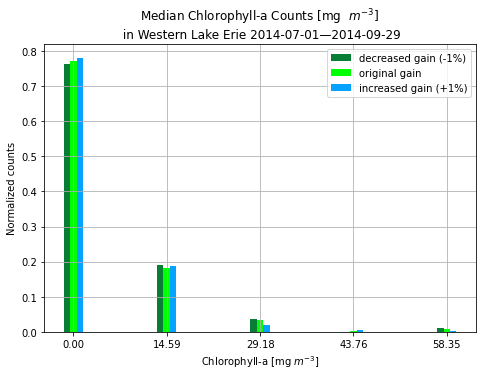

In [ ]:

def IndexHisto(img, img_plus, img_minus):
  '''
  indexname should be a string with quotations ex: 'NDVI'
  '''
  
  # This function maps spectral indices using Landsat 8 Imagery//TODO: POTENTIALLY ADD MORE
  
  def indicise(image):
    selected = image.select('chlora')
    print(selected.getInfo())
    #projection = image.projection().nominalScale()
    #print('projection', projection.getInfo())
    #a = np.array(selected.reduceRegion(ee.Reducer.fixedHistogram(0, 1.0, 5), roi_erie, 40).get('chlora').getInfo())
    
    a = np.array(selected.reduceRegion(**{
        'reducer': ee.Reducer.fixedHistogram(**{
            'min': 0,
            'max': max_chlora,
            'steps': 5,
            }),
            'geometry': roi_erie,
            'scale': 1000, #image.projection().nominalScale(),
            'maxPixels': 1e8
            }).get('chlora').getInfo())
    print(a)
    x = a[:, 0]
    y = a[:, 1] / np.sum(a[:, 1])
    return x, y
    #gcvi = np.array(indicised.select('GCVI').getInfo())
  
  unperturbed = indicise(img)
  plus = indicise(img_plus)
  minus = indicise(img_minus)

  legend_size = 10
  fig = plt.figure()
  plt.grid()
  ax = fig.add_axes([0,0,1,1])

  wdth = 1

  plt.grid()
  plt.bar(minus[0] - wdth, minus[1], width = wdth, color = '#077d36', alpha = 1, label = "decreased gain (-1%)")
  plt.bar(unperturbed[0], unperturbed[1], width = wdth, color = '#00FF00', alpha = 1, label = "original gain")
  plt.bar(plus[0] + wdth , plus[1], width = wdth, color = '#05a3ff', alpha = 1, label = "increased gain (+1%)")

  plt.xticks(unperturbed[0])

  plt.title("Median Chlorophyll-a Counts [mg  $m^{-3}$] \n in Western Lake Erie " + date_range[0]+"—"+date_range[1])
  plt.xlabel('Chlorophyll-a [mg $m ^{-3}$]')
  plt.ylabel('Normalized counts')

  plt.legend(loc='best', fancybox=True, fontsize = legend_size)

  plt.show()
  #fig, axs = plt.subplots(1, 1, sharey = True)
  #axs.hist(ndvi, bins = n_bins)
  #axs[1].hist(gcvi, bins = n_bins)


IndexHisto(unperturbed_chlora, perturbed_chlora_plus, perturbed_chlora_minus)



###Histogram

##Decisionmaking 